<a href="https://colab.research.google.com/github/allan-jt/IJEPA-Thermal-Benchmark/blob/notebook/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries



In [1]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [2]:
import requests
from PIL import Image
from torch.nn.functional import cosine_similarity
from transformers import AutoModel, AutoProcessor
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
model_id = "facebook/ijepa_vith14_22k"
batch_size = 32

# Data Loader

In [5]:
import kagglehub
path = kagglehub.dataset_download("breejeshdhar/thermal-image-dataset-for-object-classification")

100%|██████████| 3.24G/3.24G [00:24<00:00, 144MB/s]

Extracting files...


In [6]:
import os
!mv {path} {os.getcwd()}

In [39]:
# Define the folder paths
base_path = "/content/1/Thermal Image Dataset/SeekThermal/Train"
car_folder = os.path.join(base_path, "Car")
cat_folder = os.path.join(base_path, "Cat")
temp_folder = os.path.join(base_path, "TempFolder")

# Rename the folders
os.rename(car_folder, temp_folder)  # Rename "Car" to "TempFolder"
os.rename(cat_folder, car_folder)  # Rename "Cat" to "Car"
os.rename(temp_folder, cat_folder)  # Rename "TempFolder" to "Cat"

base_path = "/content/1/Thermal Image Dataset/SeekThermal/Test"
car_folder = os.path.join(base_path, "car")
cat_folder = os.path.join(base_path, "cat")
man_folder = os.path.join(base_path, "man")

Car_folder = os.path.join(base_path, "Car")
Cat_folder = os.path.join(base_path, "Cat")
Man_folder = os.path.join(base_path, "Man")

os.rename(car_folder, Car_folder)
os.rename(cat_folder, Cat_folder)
os.rename(man_folder, Man_folder)

FileNotFoundError: [Errno 2] No such file or directory: '/content/1/Thermal Image Dataset/SeekThermal/Test/car' -> '/content/1/Thermal Image Dataset/SeekThermal/Test/Car'

In [37]:
# Paths to Train and Test directories
train_dir = "/content/1/Thermal Image Dataset/SeekThermal/Train"
test_dir = "/content/1/Thermal Image Dataset/SeekThermal/Test"

# Subdirectories
categories = ["Cat", "Car", "Man"]

for category in categories:
    # Paths for the current category in Train and Test
    train_path = os.path.join(train_dir, category)
    test_path = os.path.join(test_dir, category)

    # Get list of files in Train and Test directories
    train_files = set(os.listdir(train_path))
    test_files = set(os.listdir(test_path))

    # Find overlapping files
    overlapping_files = train_files & test_files

    # Remove overlapping files from Train directory
    for file in overlapping_files:
        file_path = os.path.join(train_path, file)
        os.remove(file_path)

print("Cleanup complete!")


FileNotFoundError: [Errno 2] No such file or directory: '/content/1/Thermal Image Dataset/SeekThermal/Test/Cat'

In [8]:
# def fix_exif_orientation(image):
#     return ImageOps.exif_transpose(image)

processor = AutoProcessor.from_pretrained(model_id)
transform = transforms.Compose([
    transforms.Lambda(lambda img: ImageOps.exif_transpose(img)),  # Fix EXIF orientation
    transforms.Lambda(lambda img: processor(img, return_tensors="pt")["pixel_values"].squeeze(0))  # Apply processor
])


# transform = transforms.Compose([
#     transforms.Lambda(fix_exif_orientation),
#     transforms.Resize((400, 300)),  # Resize images
#     transforms.ToTensor(),          # Convert to tensor
# ])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/497 [00:00<?, ?B/s]

In [9]:
# Load the dataset
# The test and train folder should follow their orginal structure where there are 3 subfolders, one for each class
train_dataset = datasets.ImageFolder(root='/content/1/Thermal Image Dataset/SeekThermal/Train', transform=transform)
test_dataset = datasets.ImageFolder(root='/content/1/Thermal Image Dataset/SeekThermal/Test', transform=transform)

In [10]:
# Define split ratios
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
torch.manual_seed(42)  # Set seed for reproducibility
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [11]:
# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [12]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Testing data size: {len(test_dataset)}")
print(train_dataset.class_to_idx)

Train data size: 3785
Validation data size: 947
Testing data size: 1068
{'Car': 0, 'Cat': 1, 'Man': 2}


In [14]:
# Verify a batch from train_loader
from PIL import Image, ImageOps
from IPython.display import display
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")  # Example: [32, 3, 300, 400]
    print(f"Batch labels: {labels}")            # Example: tensor([0, 1, ...])
    print(images[0])
    print(labels[0])
    break

Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 0, 1, 2, 0, 0, 0, 2, 2, 2, 1, 0, 2, 1, 1, 1, 2, 0, 0, 1, 0, 2, 0, 2,
        2, 0, 0, 2, 1, 1, 2, 0])
tensor([[[ 0.9922,  0.9922,  0.9922,  ..., -1.0000, -1.0000, -1.0000],
         [ 1.0000,  1.0000,  1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [ 0.9922,  0.9922,  0.9922,  ..., -0.9922, -1.0000, -1.0000],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -1.0000]],

        [[ 0.9922,  0.9922,  0.9922,  ..., -0.7490, -0.6235, -0.5059],
         [ 0.9843,  0.9843,  0.9843,  ..., -0.7176, -0.6627, -0.6078],
         [ 0.9608,  0.9608,  0.9608,  ..., -0.6941, -0.7020, -0.7490],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.6392, -0.7725, -0.9294],
         [-1.0000, -1.0000, -1.0000,  ..., -0.7020, -0.8118, -0.9765],
         [-1.

# Loading Backbone

In [15]:
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ClassificationHead, self).__init__()

        self.model = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.model(x)

In [16]:
class TransformerWithClassificationHead(nn.Module):
    def __init__(self, vit, output_dim, withLayerNorm=False):
        super(TransformerWithClassificationHead, self).__init__()
        self.vit = vit
        self.vit.requires_grad_(False)
        self.layer_norm = None
        if withLayerNorm:
            self.layer_norm = nn.LayerNorm(self.vit.config.hidden_size)
        self.classification_head = ClassificationHead(
            self.vit.config.hidden_size,
            output_dim,
        )
        self.classification_head.requires_grad_(True)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values)
        cls_token = outputs.last_hidden_state[:, 0, :]
        if self.layer_norm is not None:
          cls_token = self.layer_norm(cls_token)
        return self.classification_head(cls_token)

# Set up Trainer

In [17]:
backbone = AutoModel.from_pretrained(model_id)

model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

In [18]:
model = TransformerWithClassificationHead(
    backbone,
    3,
)

In [19]:
import torch.optim as optim
from tqdm import tqdm

In [20]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for inputs, labels in tqdm(dataloader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return epoch_loss / len(dataloader), accuracy

In [21]:
def evaluate_epoch(model, dataloader, criterion, device):
    model.eval()
    epoch_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return epoch_loss / len(dataloader), accuracy

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# Training parameters
num_epochs = 10
best_accuracy = 0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, train_accuracy = train_epoch(
        model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Evaluate
    val_loss, val_accuracy = evaluate_epoch(
        model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


    # Save the best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")
        print("Best model saved!")

print(f"Training complete. Best Validation Accuracy: {best_accuracy:.2f}%")

Epoch 1/10


Training: 100%|██████████| 119/119 [05:55<00:00,  2.99s/it]


Training Loss: 0.9788, Training Accuracy: 53.95%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.06s/it]


Validation Loss: 0.8245, Validation Accuracy: 69.59%
Best model saved!
Epoch 2/10


Training: 100%|██████████| 119/119 [06:05<00:00,  3.07s/it]


Training Loss: 0.7526, Training Accuracy: 73.55%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.05s/it]


Validation Loss: 0.6695, Validation Accuracy: 79.09%
Best model saved!
Epoch 3/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.07s/it]


Training Loss: 0.6364, Training Accuracy: 80.05%


Evaluating: 100%|██████████| 30/30 [01:32<00:00,  3.08s/it]


Validation Loss: 0.5830, Validation Accuracy: 83.32%
Best model saved!
Epoch 4/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.07s/it]


Training Loss: 0.5634, Training Accuracy: 82.62%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.05s/it]


Validation Loss: 0.5300, Validation Accuracy: 84.90%
Best model saved!
Epoch 5/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.07s/it]


Training Loss: 0.5131, Training Accuracy: 83.59%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.04s/it]


Validation Loss: 0.4875, Validation Accuracy: 85.85%
Best model saved!
Epoch 6/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.06s/it]


Training Loss: 0.4755, Training Accuracy: 85.28%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.06s/it]


Validation Loss: 0.4579, Validation Accuracy: 85.22%
Epoch 7/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.06s/it]


Training Loss: 0.4474, Training Accuracy: 85.79%


Evaluating: 100%|██████████| 30/30 [01:32<00:00,  3.07s/it]


Validation Loss: 0.4316, Validation Accuracy: 86.48%
Best model saved!
Epoch 8/10


Training: 100%|██████████| 119/119 [06:05<00:00,  3.07s/it]


Training Loss: 0.4250, Training Accuracy: 86.10%


Evaluating: 100%|██████████| 30/30 [01:32<00:00,  3.07s/it]


Validation Loss: 0.4146, Validation Accuracy: 86.80%
Best model saved!
Epoch 9/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.06s/it]


Training Loss: 0.4048, Training Accuracy: 86.76%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.06s/it]


Validation Loss: 0.3955, Validation Accuracy: 87.65%
Best model saved!
Epoch 10/10


Training: 100%|██████████| 119/119 [06:04<00:00,  3.07s/it]


Training Loss: 0.3902, Training Accuracy: 87.29%


Evaluating: 100%|██████████| 30/30 [01:31<00:00,  3.06s/it]

Validation Loss: 0.3818, Validation Accuracy: 87.54%
Training complete. Best Validation Accuracy: 87.65%


# Results

In [ ]:
test_loss, test_accuracy = evaluate_epoch(
        model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [23]:
# Test set
best_model_path = "best_model.pth"
model.load_state_dict(torch.load(best_model_path, weights_only=True))
test_loss, test_accuracy = evaluate_epoch(
        model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Evaluating: 100%|██████████| 34/34 [01:42<00:00,  3.02s/it]

Test Loss: 0.3718, Test Accuracy: 88.67%


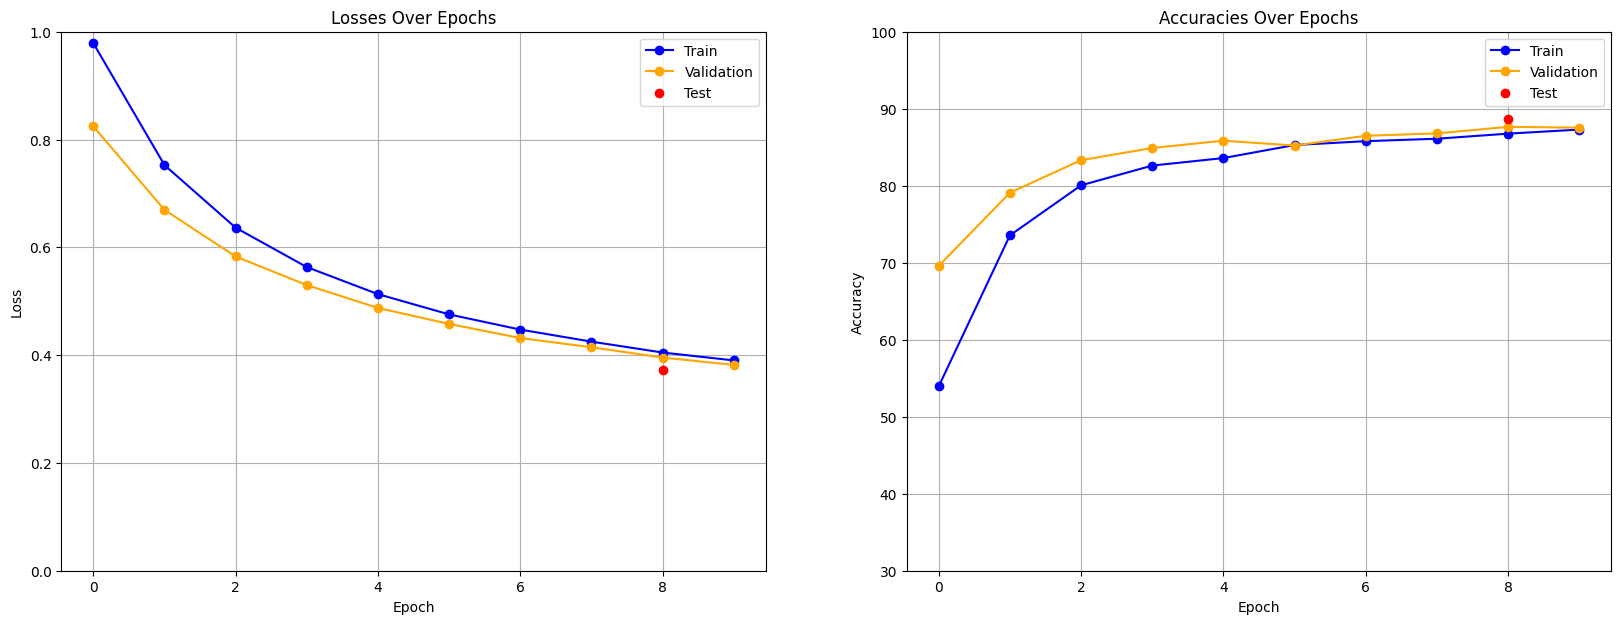

In [36]:
plt.figure(figsize=(20, 7))  # Adjust the size of the plot

# Plot for Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train', marker='o', color='blue')
plt.plot(val_losses, label='Validation', marker='o', color='orange')
plt.scatter([best_epoch], [test_loss], color='red', label='Test', zorder=5)
plt.title('Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)


# Plot for Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train', marker='o', color='blue')
plt.plot(val_accuracies, label='Validation', marker='o', color='orange')
plt.scatter([best_epoch], [test_accuracy], color='red', label='Test', zorder=5)
plt.title('Accuracies Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(30, 100)

plt.show()